In [1]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [2]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector])
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [3]:
def get_xhigh(eq_id):
    
    if eq_id == '2023-04-13_M6':
        xhigh = 60
    elif eq_id == '2022-12-20_M6.4':
        if hypdist < 200:
            xhigh = 20
        else:
            xhigh = 40
    elif eq_id == '2022-11-22_M6.2': # Weird one that pauses for a while then grows again
        xhigh = 25
    elif eq_id == '2021-12-20_M6.2':
        if hypdist < 30: 
            xhigh = 20
        elif 30 < hypdist < 50:
            xhigh = 25
        elif 50 < hypdist < 100:
            xhigh = 30
        else:
            xhigh = 60
    elif eq_id == '2021-07-08_M6': # Lots of more gradual ones with pause again
        if hypdist < 300:
            xhigh = 25
        else:
            xhigh = 50
    elif eq_id == '2020-05-15_M6.5':
        xhigh = 30
    elif eq_id == '2020-03-31_M6.5':
        xhigh = 35
    elif eq_id == '2019-12-25_M6.3':
        xhigh = 35
    elif eq_id == '2019-12-23T20_M6':
        xhigh = 60
    elif eq_id == '2019-12-23T19_M6':
        xhigh = 60
    elif eq_id == '2019-08-29_M6.3': # All flatten fast
        xhigh = 60
    elif eq_id == '2019-07-06_M7.1': # Ridgecrest mainshock
        xhigh = 27
    elif eq_id == '2019-07-04_M6.4': # Ridgecrest foreshock
        if hypdist < 50:
            xhigh = 20
        else:
            xhigh = 27
    elif eq_id == '2019-07-04_M6.2':
        xhigh = 35
    # elif eq_id == '2018-10-22T06_M6.5': # No waveforms with high enough SNR
    #     xhigh = 
    elif eq_id == '2018-10-22_M6.8': # Has like 3 slopes? Letting it go long
        xhigh = 60
    elif eq_id == '2018-10-22T05_M6.5': # Somewhat of a pause but all similar? Going long
        xhigh = 60
    elif eq_id == '2018-08-22_M6.2':
        xhigh = 60
    elif eq_id == '2016-12-08_M6.6':
        xhigh = 60
    elif eq_id == '2014-08-24_M6.02':
        xhigh = 27
    elif eq_id == '2014-04-24_M6.5':
        xhigh = 50
    elif eq_id == '2014-03-10_M6.8':
        if hypdist < 110:
            xhigh = 25
        else:
            xhigh = 40
    elif eq_id == '2013-09-04_M6':
        xhigh = 25
    elif eq_id == '2013-09-03_M6.1':
        xhigh = 30
    elif eq_id == '2012-12-14_M6.3':
        xhigh = 25
    elif eq_id == '2012-11-08_M6.1':
        xhigh = 42
    elif eq_id == '2012-04-11_M6':
        xhigh = 30
    elif eq_id == '2011-09-09_M6.4':
        xhigh = 35
    elif eq_id == '2010-04-04_M7.2':
        xhigh = 35
    elif eq_id == '2010-01-10_M6.5':
        xhigh = 35
    elif eq_id == '2008-01-10_M6.3':
        xhigh = 24
    else:
        xhigh = 'no data'
    
    return xhigh

In [4]:
# Events

path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

In [5]:
# earthquakes

In [5]:
weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]

small_test = False
if small_test:
    earthquakes = earthquakes.iloc[[11,12,13]]
    
one_at_a_time = False
if one_at_a_time:
#     earthquakes = earthquakes[:1]
    earthquakes = earthquakes.iloc[[29]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

# Stations

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs_FILTERED.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

In [ ]:
events_list = []
mags_list = []
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

counter = 0

for idx in range(len(dist_array)):
    
    eq_id = dist_array[idx,0]
    mag = dist_array[idx,4]
    sta = dist_array[idx,5]

    # print(eq_id, sta)

    # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)

    xlow = 10
    xhigh = get_xhigh(eq_id)
        
    try:

        hypdist = float(dist_array[idx,8])
        int_hypdist = int(hypdist)
        snr = float(dist_array[idx,9])
        int_snr = int(snr) # Breaks try condition if snr is nan
        
        # Read in data - peak strain data only has the ones with SNR > 2
        pst = read(path_to_files + 'strain_data/filtered_peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
        counter += 1
        # print(counter)
        # pst.plot()
        # plt.plot(pst[0].times(), pst[0].data)
        # plt.semilogy()

        print('Processing ' + str(eq_id) + ', ' + str(sta))

    except:
        continue # skips to next station

    print('Processing ' + str(sta))
        
    times = pst[0].times()
    data = pst[0].data
    log10_data = np.log10(data)
    samp_rate = pst[0].stats.sampling_rate
    print(samp_rate)

    vec_start = int(xlow*samp_rate)
    vec_end = int(xhigh*samp_rate)

    # Split into x and y vectors
    xobserved = times[vec_start:vec_end]
    yobserved = log10_data[vec_start:vec_end]
    x0 = xobserved[0]
    y0 = yobserved[0]

    # in order to pass the x variable into the target function it needs to be 
    # converted to a Theano "shared" variable
    pt_xobserved = pytensor.shared(xobserved)
    pt_x0 = pytensor.shared(x0)
    pt_y0 = pytensor.shared(y0)

    # MCMC run parameters, these are good numbers for a "production" run. If you are
    # fooling arund these can be lower to iterate faster
    Nburn = 5000 # burn in samples that get discarded
    Nmcmc = 15000 # bump to at least 5-10k
    Nchains = 4
    Ncores = 1

    # Bounds for the prior distributions
    m1_low = -1; m1_high = 5
    m2_low = -1; m2_high = 1
    xinter_low = 10 ; xinter_high = 25 # location of the line slope change

    # Define the Bayesian model
    with pm.Model()as model:

        # Use normal distributions as priors
        # m1 = pm.Normal('m1', mu = 0.5, sigma = 1)
        # m2 = pm.Normal('m2', mu = -0.1, sigma = 5)
        m1 = pm.Uniform('m1', lower = m1_low, upper = m1_high)
        m2 = pm.Uniform('m2', lower = m2_low, upper = m2_high)
        xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
        sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1)

        # This is the model
        likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                observed = yobserved, sigma = sigma)

        # NUTS sampler (default) is gradient based and won't work, use metropolis
        step = pm.Metropolis(scaling = 0.1)

        # This runs the mcmc sampler
        mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)

    # Done, now is post-processing to get the data out of the sampler

    posterior = az.extract(mcmc)

    # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
    m1_array = posterior.m1.values
    m1 = np.mean(m1_array)
    # print('m1 mean: ' + str(round(m1,2)))

    m2_array = posterior.m2.values
    m2 = np.mean(m2_array)
    # print('m2 mean: ' + str(round(m2,2)))

    xinter_array = posterior.xinter.values
    xinter = np.mean(xinter_array)
    # print('xinter Mean: ' + str(round(xinter,2)))

    sigma_array = posterior.sigma.values
    sigma = np.mean(sigma_array)

    # Lines!
    b1 = y0 - m1*x0
    b2 = m1*xinter + b1 - m2*xinter

    # Make plot to check stuff
    xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
    ypredicted = m1*xpredicted + b1
    i = np.where(xpredicted > xinter)[0]
    ypredicted[i] = m2*xpredicted[i] + b2

    # Get one-sigma region (need to obtain a ton of forward models and get stats)
    N = len(posterior.m1.values)

    yfit = np.zeros((len(xpredicted), N))
    for k in range(N):
        yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
    mu = yfit.mean(1)
    sig = yfit.std(1) * 1.95 #for 95% confidence
    mu_plus = mu + sig
    mu_minus = mu - sig

    # Least squares
    mls, bls = np.polyfit(xobserved, yobserved, 1)

    # Find the transition point in ypredicted
    diff = np.round(np.diff(ypredicted), decimals = 5)
    # print(diff)
    first_slope = diff[0]
    second_slope = diff[-1]
    trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1

    # Get the transition point
    mcmc_trans_x = xpredicted[trans_idx] # Number
    mcmc_trans_y = ypredicted[trans_idx]

    # Append things
    events_list.append(eq_id)
    mags_list.append(mag)
    stas_list.append(sta)
    hypdist_list.append(int_hypdist)
    xhighs_list.append(xhigh)
    m1s_list.append(m1)
    m2s_list.append(m2)
    xinters_list.append(xinter)
    sigmas_list.append(sigma)
    trans_time_list.append(mcmc_trans_x)

    # Create folder for the event
    array_save_dir = path_to_files + 'filtered_mcmc_arrays/' + str(eq_id) + '/' + str(sta) + '/'
    if os.path.isdir(array_save_dir):
        pass
    else:
        os.makedirs(array_save_dir)

    np.save(array_save_dir + 'xobserved.npy', xobserved)
    np.save(array_save_dir + 'yobserved.npy', yobserved)
    np.save(array_save_dir + 'xpredicted.npy', xpredicted)
    np.save(array_save_dir + 'ypredicted.npy', ypredicted)
    np.save(array_save_dir + 'forward_mus.npy', mu)
    np.save(array_save_dir + 'foward_sigs.npy', sig)

    summary = az.summary(mcmc, fmt = 'wide')
    print(summary)
    summary.to_csv(array_save_dir + 'mcmc_summary.csv', index = False)

    # Folder for figures
    fig_save_dir = path_to_files + 'figures/filtered_mcmc_plots/' + str(eq_id) + '/'
    if os.path.isdir(fig_save_dir):
        pass
    else:
        os.makedirs(fig_save_dir)

    az.plot_trace(mcmc)
    # plt.show()
    plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
    plt.close()

    # Plot all solutions
    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(111)
    ax.set_title(str(sta))

    ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
    ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
    # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
    # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
    ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
    # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
    # ax2 = ax.twinx()
    # ax2.plot(xobserved, pythags_arr, color = 'violet')
    # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
    ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval
    ax.set_xlabel('Time (s) - p-wave at 10s')
    ax.set_ylabel('log10 of peak strain')
    # ax.set_xlim(10,13)
    ax.legend()

    # plt.show()

    plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
    plt.close()

Processing 2023-04-13_M6, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 127 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.179  0.025   0.146    0.222      0.011    0.008       5.0   
m2       0.018  0.000   0.017    0.018      0.000    0.000      11.0   
xinter  13.294  0.465  12.499   14.179      0.213    0.162       5.0   
sigma    0.080  0.002   0.076    0.083      0.000    0.000      34.0   

        ess_tail  r_hat  
m1          12.0   2.49  
m2          12.0   1.29  
xinter      11.0   2.51  
sigma       63.0   1.07  
Processing 2023-04-13_M6, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.237  0.310   0.802    1.820      0.151    0.116       5.0   
m2       0.010  0.000   0.010    0.010      0.000    0.000       8.0   
xinter  11.181  0.293  10.730   11.680      0.138    0.105       5.0   
sigma    0.069  0.009   0.056    0.087      0.004    0.003       5.0   

        ess_tail  r_hat  
m1          11.0   2.65  
m2          32.0   1.48  
xinter      11.0   2.65  
sigma       19.0   2.47  
Processing 2023-04-13_M6, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.602  0.057   0.483    0.689      0.026    0.020       5.0   
m2       0.013  0.000   0.013    0.013      0.000    0.000       8.0   
xinter  11.667  0.181  11.436   12.078      0.082    0.062       5.0   
sigma    0.062  0.002   0.058    0.067      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          20.0   2.67  
m2          19.0   1.48  
xinter      20.0   2.67  
sigma       21.0   1.30  
Processing 2022-12-20_M6.4, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 104 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.139  0.004   0.133    0.146      0.001    0.001      27.0   
m2       0.035  0.001   0.034    0.036      0.000    0.000      84.0   
xinter  14.306  0.157  14.004   14.582      0.023    0.016      46.0   
sigma    0.101  0.003   0.096    0.107      0.000    0.000   12136.0   

        ess_tail  r_hat  
m1          83.0   1.10  
m2         124.0   1.06  
xinter     115.0   1.06  
sigma    13141.0   1.00  
Processing 2022-12-20_M6.4, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.113  0.003   0.108    0.117      0.000    0.000      49.0   
m2       0.037  0.001   0.036    0.037      0.000    0.000     123.0   
xinter  15.452  0.200  15.099   15.850      0.025    0.017      66.0   
sigma    0.085  0.002   0.081    0.090      0.000    0.000   12860.0   

        ess_tail  r_hat  
m1         113.0   1.04  
m2         131.0   1.02  
xinter     191.0   1.04  
sigma    12881.0   1.00  
Processing 2022-12-20_M6.4, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.217  0.004   0.209    0.223      0.001    0.001      13.0   
m2       0.032  0.000   0.031    0.032      0.000    0.000      30.0   
xinter  14.082  0.093  13.939   14.272      0.027    0.020      12.0   
sigma    0.071  0.002   0.068    0.075      0.000    0.000   12271.0   

        ess_tail  r_hat  
m1          63.0   1.23  
m2          92.0   1.11  
xinter      38.0   1.24  
sigma    13014.0   1.00  
Processing 2022-12-20_M6.4, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.077  0.065   0.955    1.198      0.028    0.021       6.0   
m2       0.027  0.001   0.026    0.028      0.000    0.000      34.0   
xinter  11.406  0.097  11.244   11.602      0.041    0.030       6.0   
sigma    0.099  0.003   0.093    0.105      0.000    0.000      59.0   

        ess_tail  r_hat  
m1          14.0   1.90  
m2          41.0   1.08  
xinter      15.0   1.91  
sigma      113.0   1.04  
Processing 2022-12-20_M6.4, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.906  0.065   0.801    1.037      0.029    0.022       5.0   
m2       0.023  0.001   0.022    0.024      0.000    0.000      19.0   
xinter  11.767  0.140  11.515   12.005      0.062    0.047       5.0   
sigma    0.121  0.004   0.114    0.128      0.000    0.000     115.0   

        ess_tail  r_hat  
m1          17.0   2.13  
m2         127.0   1.16  
xinter      17.0   2.09  
sigma     1486.0   1.02  
Processing 2022-12-20_M6.4, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.352  0.007   0.341    0.366      0.001    0.001      39.0   
m2       0.047  0.001   0.046    0.048      0.000    0.000     142.0   
xinter  12.973  0.074  12.823   13.101      0.011    0.008      44.0   
sigma    0.110  0.003   0.104    0.116      0.000    0.000   11933.0   

        ess_tail  r_hat  
m1          37.0   1.10  
m2         249.0   1.02  
xinter      34.0   1.10  
sigma    13769.0   1.00  
Processing 2022-12-20_M6.4, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.892  0.017   0.859    0.924      0.003    0.002      48.0   
m2       0.026  0.004   0.018    0.033      0.000    0.000     318.0   
xinter  11.949  0.046  11.859   12.034      0.007    0.005      49.0   
sigma    0.107  0.006   0.097    0.118      0.000    0.000   11922.0   

        ess_tail  r_hat  
m1          79.0   1.07  
m2         573.0   1.01  
xinter      82.0   1.06  
sigma    14825.0   1.00  
Processing 2022-12-20_M6.4, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 108 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.430  0.680   3.063    5.000      0.297    0.228       6.0   
m2       0.013  0.001   0.011    0.016      0.000    0.000       8.0   
xinter  10.750  0.148  10.634   11.066      0.061    0.045       6.0   
sigma    0.171  0.015   0.152    0.205      0.006    0.004       7.0   

        ess_tail  r_hat  
m1          30.0   1.93  
m2          41.0   1.40  
xinter      31.0   1.94  
sigma       33.0   1.52  
Processing 2022-12-20_M6.4, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.933  0.211   1.604    2.317      0.086    0.064       6.0   
m2       0.141  0.003   0.134    0.147      0.001    0.000      27.0   
xinter  10.630  0.078  10.499   10.761      0.032    0.024       6.0   
sigma    0.112  0.006   0.101    0.123      0.000    0.000   10556.0   

        ess_tail  r_hat  
m1          14.0   1.67  
m2         391.0   1.11  
xinter      14.0   1.68  
sigma    13479.0   1.00  
Processing 2022-12-20_M6.4, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.717  0.218   2.293    3.123      0.036    0.026      36.0   
m2       0.123  0.003   0.117    0.130      0.000    0.000     346.0   
xinter  10.471  0.040  10.388   10.542      0.007    0.005      35.0   
sigma    0.133  0.007   0.120    0.145      0.000    0.000   12231.0   

        ess_tail  r_hat  
m1         123.0   1.10  
m2         930.0   1.02  
xinter     128.0   1.10  
sigma    13762.0   1.00  
Processing 2022-11-22_M6.2, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.867  0.917   0.083    2.414      0.435    0.330       6.0   
m2       0.036  0.010   0.024    0.047      0.005    0.004       6.0   
xinter  13.440  3.252  10.065   16.902      1.623    1.244       6.0   
sigma    0.067  0.005   0.058    0.076      0.002    0.002       6.0   

        ess_tail  r_hat  
m1          47.0   1.96  
m2         144.0   1.77  
xinter      37.0   1.96  
sigma       76.0   1.69  
Processing 2022-11-22_M6.2, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.389  0.009   0.373    0.406      0.001    0.001      37.0   
m2       0.044  0.003   0.040    0.050      0.000    0.000     130.0   
xinter  13.388  0.113  13.189   13.606      0.020    0.015      30.0   
sigma    0.129  0.005   0.119    0.139      0.000    0.000   12839.0   

        ess_tail  r_hat  
m1         154.0   1.10  
m2         481.0   1.05  
xinter     212.0   1.12  
sigma    14707.0   1.00  
Processing 2022-11-22_M6.2, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.123  0.001   0.121    0.125      0.000    0.000     102.0   
m2       0.035  0.004   0.028    0.042      0.000    0.000     542.0   
xinter  18.870  0.197  18.488   19.222      0.016    0.012     148.0   
sigma    0.076  0.003   0.070    0.082      0.000    0.000   11806.0   

        ess_tail  r_hat  
m1         178.0   1.05  
m2        1039.0   1.02  
xinter     344.0   1.04  
sigma    14344.0   1.00  
Processing 2022-11-22_M6.2, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.094  0.001   0.093    0.095      0.000    0.000     143.0   
m2      -0.001  0.005  -0.011    0.009      0.000    0.000     870.0   
xinter  21.120  0.142  20.857   21.389      0.006    0.004     584.0   
sigma    0.053  0.002   0.049    0.057      0.000    0.000   13086.0   

        ess_tail  r_hat  
m1         142.0   1.04  
m2        1403.0   1.00  
xinter    1508.0   1.01  
sigma    15300.0   1.00  
Processing 2021-12-20_M6.2, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.175  0.033   0.165    0.176      0.010    0.007       7.0   
m2       0.013  0.003   0.012    0.014      0.001    0.001      47.0   
xinter  21.504  1.458  21.264   22.234      0.455    0.337       8.0   
sigma    0.157  0.022   0.144    0.162      0.007    0.005      33.0   

        ess_tail  r_hat  
m1          12.0   1.57  
m2          12.0   1.09  
xinter      12.0   1.49  
sigma       12.0   1.08  
Processing 2021-12-20_M6.2, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.149  0.001   0.146    0.151       0.00    0.000      15.0   
m2       0.009  0.000   0.009    0.010       0.00    0.000      27.0   
xinter  22.278  0.118  22.065   22.535       0.03    0.022      18.0   
sigma    0.118  0.003   0.113    0.123       0.00    0.000    9916.0   

        ess_tail  r_hat  
m1          14.0   1.20  
m2          95.0   1.14  
xinter      15.0   1.16  
sigma    11592.0   1.00  
Processing 2021-12-20_M6.2, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.828  0.148   0.577    1.074      0.072    0.055       4.0   
m2       0.028  0.000   0.027    0.029      0.000    0.000       8.0   
xinter  11.502  0.288  11.031   12.044      0.140    0.107       4.0   
sigma    0.105  0.003   0.099    0.111      0.001    0.001      11.0   

        ess_tail  r_hat  
m1          10.0   3.26  
m2          26.0   1.45  
xinter      11.0   3.28  
sigma       20.0   1.28  
Processing 2021-12-20_M6.2, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.700  0.125   0.504    0.917      0.060    0.046       5.0   
m2       0.026  0.001   0.024    0.026      0.000    0.000       7.0   
xinter  12.187  0.436  11.523   12.945      0.210    0.160       5.0   
sigma    0.169  0.004   0.162    0.178      0.001    0.001      18.0   

        ess_tail  r_hat  
m1          11.0   2.94  
m2          19.0   1.63  
xinter      11.0   2.97  
sigma       44.0   1.14  
Processing 2021-12-20_M6.2, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.179  0.024   0.165    0.225      0.008    0.006       7.0   
m2       0.001  0.001  -0.001    0.004      0.000    0.000       9.0   
xinter  17.838  0.928  15.765   18.555      0.346    0.259       7.0   
sigma    0.098  0.011   0.089    0.123      0.003    0.003      11.0   

        ess_tail  r_hat  
m1          17.0   1.65  
m2          16.0   1.40  
xinter      17.0   1.66  
sigma       17.0   1.27  
Processing 2021-12-20_M6.2, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.293  0.010   1.273    1.311      0.002    0.002      19.0   
m2      -0.000  0.001  -0.002    0.002      0.000    0.000     157.0   
xinter  11.384  0.012  11.363   11.408      0.003    0.002      24.0   
sigma    0.038  0.002   0.035    0.042      0.000    0.000   10718.0   

        ess_tail  r_hat  
m1          80.0   1.16  
m2         166.0   1.03  
xinter      64.0   1.13  
sigma    14395.0   1.00  
Processing 2021-12-20_M6.2, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.914  0.078   0.785    1.052      0.036    0.027       5.0   
m2       0.015  0.000   0.015    0.016      0.000    0.000      11.0   
xinter  11.459  0.131  11.239   11.680      0.060    0.045       5.0   
sigma    0.090  0.002   0.085    0.094      0.001    0.000      21.0   

        ess_tail  r_hat  
m1          25.0   2.24  
m2          30.0   1.27  
xinter      25.0   2.29  
sigma       81.0   1.12  
Processing 2021-12-20_M6.2, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.137  0.023   0.121    0.188      0.009    0.007       5.0   
m2       0.004  0.002   0.001    0.009      0.001    0.001       6.0   
xinter  20.933  1.718  16.879   22.650      0.730    0.553       5.0   
sigma    0.111  0.012   0.099    0.142      0.005    0.003       9.0   

        ess_tail  r_hat  
m1          20.0   2.06  
m2          16.0   1.89  
xinter      19.0   2.08  
sigma       18.0   1.38  
Processing 2021-12-20_M6.2, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.045  1.003   0.744    3.896      0.486    0.370       5.0   
m2       0.013  0.001   0.012    0.014      0.000    0.000      12.0   
xinter  10.862  0.388  10.305   11.549      0.179    0.135       5.0   
sigma    0.193  0.007   0.180    0.206      0.003    0.002       8.0   

        ess_tail  r_hat  
m1          13.0   2.63  
m2          34.0   1.26  
xinter      13.0   2.63  
sigma       32.0   1.46  
Processing 2021-12-20_M6.2, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.854  0.116   2.629    3.103      0.041    0.030       9.0   
m2       0.039  0.001   0.037    0.041      0.000    0.000      69.0   
xinter  10.721  0.032  10.664   10.789      0.012    0.009       9.0   
sigma    0.082  0.004   0.075    0.089      0.000    0.000      82.0   

        ess_tail  r_hat  
m1          11.0   1.38  
m2         264.0   1.07  
xinter      11.0   1.40  
sigma      110.0   1.03  
Processing 2021-12-20_M6.2, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 127 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.887  0.145   0.574    1.130      0.038    0.028      15.0   
m2       0.083  0.001   0.081    0.085      0.000    0.000      97.0   
xinter  10.741  0.182  10.520   11.123      0.042    0.030      15.0   
sigma    0.116  0.004   0.108    0.123      0.000    0.000    1848.0   

        ess_tail  r_hat  
m1          25.0   1.19  
m2         168.0   1.02  
xinter      28.0   1.19  
sigma     7148.0   1.00  
Processing 2021-07-08_M6, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.175  0.005   0.166    0.185      0.001    0.001      19.0   
m2       0.029  0.001   0.028    0.030      0.000    0.000     115.0   
xinter  17.057  0.297  16.481   17.620      0.063    0.045      22.0   
sigma    0.169  0.004   0.161    0.177      0.000    0.000   11711.0   

        ess_tail  r_hat  
m1          80.0   1.19  
m2         167.0   1.02  
xinter      99.0   1.16  
sigma    12149.0   1.00  
Processing 2021-07-08_M6, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.548  0.026   0.511    0.611      0.012    0.009       5.0   
m2       0.012  0.001   0.011    0.013      0.000    0.000       9.0   
xinter  13.740  0.191  13.296   14.015      0.086    0.065       5.0   
sigma    0.116  0.003   0.111    0.122      0.000    0.000      44.0   

        ess_tail  r_hat  
m1          22.0   2.23  
m2          69.0   1.36  
xinter      22.0   2.23  
sigma       99.0   1.06  
Processing 2021-07-08_M6, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.295  0.003   0.288    0.301      0.000    0.000     112.0   
m2       0.029  0.003   0.024    0.034      0.000    0.000     395.0   
xinter  15.423  0.092  15.262   15.603      0.008    0.006     134.0   
sigma    0.097  0.004   0.089    0.104      0.000    0.000   12081.0   

        ess_tail  r_hat  
m1         173.0   1.03  
m2         582.0   1.00  
xinter     248.0   1.02  
sigma    13891.0   1.00  
Processing 2021-07-08_M6, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.184  0.004   0.177    0.192      0.001    0.000      55.0   
m2       0.085  0.002   0.081    0.088      0.000    0.000     251.0   
xinter  14.477  0.241  14.055   14.925      0.032    0.023      64.0   
sigma    0.082  0.003   0.076    0.089      0.000    0.000   12232.0   

        ess_tail  r_hat  
m1          79.0   1.06  
m2         224.0   1.02  
xinter      64.0   1.05  
sigma    13342.0   1.00  
Processing 2021-07-08_M6, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.472  0.039   0.375    0.518      0.017    0.013       7.0   
m2       0.095  0.005   0.084    0.102      0.002    0.001       9.0   
xinter  12.656  0.417  12.201   13.700      0.186    0.140       7.0   
sigma    0.123  0.005   0.114    0.133      0.000    0.000     490.0   

        ess_tail  r_hat  
m1          13.0   1.52  
m2          14.0   1.39  
xinter      15.0   1.52  
sigma    13447.0   1.01  
Processing 2021-07-08_M6, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.037  0.460  -0.891    0.150      0.066    0.047       9.0   
m2       0.106  0.031   0.066    0.141      0.015    0.012       6.0   
xinter  15.104  4.628  10.000   20.030      2.301    1.764       5.0   
sigma    0.133  0.012   0.114    0.152      0.005    0.004       6.0   

        ess_tail  r_hat  
m1          24.0   1.90  
m2         160.0   1.81  
xinter      12.0   2.04  
sigma       94.0   1.72  
Processing 2021-07-08_M6, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.124  0.001   0.122    0.126      0.000     0.00       8.0   
m2       0.001  0.000   0.000    0.002      0.000     0.00      10.0   
xinter  23.320  0.155  22.931   23.587      0.055     0.04       8.0   
sigma    0.067  0.002   0.064    0.070      0.000     0.00    1624.0   

        ess_tail  r_hat  
m1          27.0   1.41  
m2          18.0   1.29  
xinter      24.0   1.47  
sigma     9219.0   1.00  
Processing 2021-07-08_M6, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.141  0.006   0.134    0.153      0.003    0.002       5.0   
m2       0.009  0.001   0.008    0.011      0.000    0.000       6.0   
xinter  18.269  0.460  17.308   18.896      0.196    0.148       5.0   
sigma    0.064  0.002   0.060    0.068      0.001    0.000      17.0   

        ess_tail  r_hat  
m1          40.0   2.08  
m2          30.0   1.76  
xinter      38.0   2.10  
sigma       50.0   1.15  
Processing 2021-07-08_M6, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.128  0.000   0.128    0.129      0.000    0.000      15.0   
m2       0.001  0.000   0.001    0.002      0.000    0.000      87.0   
xinter  23.041  0.060  22.918   23.141      0.017    0.012      16.0   
sigma    0.046  0.001   0.043    0.048      0.000    0.000    9539.0   

        ess_tail  r_hat  
m1          17.0   1.23  
m2          69.0   1.04  
xinter      23.0   1.19  
sigma    10601.0   1.00  
Processing 2021-07-08_M6, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.097  0.001   0.096    0.098      0.000    0.000      48.0   
m2       0.006  0.001   0.005    0.007      0.000    0.000      86.0   
xinter  24.970  0.031  24.914   25.000      0.003    0.002      72.0   
sigma    0.126  0.003   0.120    0.131      0.000    0.000   12134.0   

        ess_tail  r_hat  
m1          97.0   1.08  
m2         184.0   1.06  
xinter      75.0   1.02  
sigma    12268.0   1.00  
Processing 2021-07-08_M6, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.088  0.000   0.087    0.089      0.000    0.000      46.0   
m2       0.012  0.000   0.011    0.013      0.000    0.000      54.0   
xinter  24.988  0.013  24.963   25.000      0.001    0.001      88.0   
sigma    0.089  0.002   0.085    0.093      0.000    0.000   11101.0   

        ess_tail  r_hat  
m1          82.0   1.06  
m2         219.0   1.06  
xinter      76.0   1.04  
sigma    12355.0   1.00  
Processing 2021-07-08_M6, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 107 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.110  0.029   0.099    0.141      0.011    0.008       8.0   
m2       0.012  0.003   0.009    0.018      0.001    0.001      10.0   
xinter  21.332  2.010  17.150   22.487      0.840    0.643       8.0   
sigma    0.098  0.013   0.086    0.117      0.005    0.004      11.0   

        ess_tail  r_hat  
m1          11.0   1.51  
m2          12.0   1.34  
xinter      11.0   1.49  
sigma       11.0   1.26  
Processing 2020-05-15_M6.5, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.075  0.001   0.073    0.076      0.000    0.000     111.0   
m2       0.000  0.003  -0.006    0.006      0.000    0.000     514.0   
xinter  22.063  0.247  21.599   22.530      0.016    0.011     254.0   
sigma    0.093  0.003   0.087    0.099      0.000    0.000   13173.0   

        ess_tail  r_hat  
m1         110.0   1.03  
m2         764.0   1.01  
xinter     600.0   1.01  
sigma    14332.0   1.00  
Processing 2020-05-15_M6.5, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.011  0.007  -0.005    0.023      0.001    0.001     111.0   
m2       0.094  0.001   0.092    0.097      0.000    0.000     176.0   
xinter  13.207  0.312  12.627   13.777      0.031    0.022     102.0   
sigma    0.110  0.004   0.102    0.117      0.000    0.000   12311.0   

        ess_tail  r_hat  
m1          85.0   1.03  
m2         374.0   1.04  
xinter     121.0   1.04  
sigma    13288.0   1.00  
Processing 2020-05-15_M6.5, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.042  0.003   0.037    0.047      0.000     0.00     140.0   
m2       0.081  0.001   0.079    0.084      0.000     0.00     372.0   
xinter  15.462  0.412  14.640   16.228      0.029     0.02     210.0   
sigma    0.102  0.004   0.095    0.109      0.000     0.00   13753.0   

        ess_tail  r_hat  
m1         219.0   1.03  
m2         383.0   1.01  
xinter     297.0   1.01  
sigma    14191.0   1.00  
Processing 2020-05-15_M6.5, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      -0.099  0.198  -0.539    0.076      0.024    0.017      58.0   
m2       0.094  0.002   0.091    0.098      0.000    0.000     312.0   
xinter  10.942  0.690  10.059   12.180      0.093    0.066      57.0   
sigma    0.184  0.007   0.172    0.197      0.000    0.000   13324.0   

        ess_tail  r_hat  
m1         103.0   1.04  
m2         537.0   1.01  
xinter     128.0   1.04  
sigma    13703.0   1.00  
Processing 2020-03-31_M6.5, B944
Processing B944
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 121 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.095  0.001   0.094    0.096      0.000     0.00      43.0   
m2       0.044  0.002   0.041    0.047      0.000     0.00     288.0   
xinter  23.406  0.214  23.012   23.809      0.014     0.01     232.0   
sigma    0.089  0.003   0.084    0.095      0.000     0.00   12671.0   

        ess_tail  r_hat  
m1          73.0   1.07  
m2         493.0   1.02  
xinter     716.0   1.02  
sigma    14250.0   1.00  
Processing 2019-12-25_M6.3, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.131  0.002   0.127    0.135      0.000    0.000      74.0   
m2       0.021  0.001   0.020    0.022      0.000    0.000     172.0   
xinter  15.412  0.107  15.203   15.605      0.011    0.007     102.0   
sigma    0.073  0.002   0.069    0.078      0.000    0.000   11979.0   

        ess_tail  r_hat  
m1         146.0   1.03  
m2         288.0   1.02  
xinter     143.0   1.03  
sigma    13786.0   1.00  
Processing 2019-12-25_M6.3, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.259  0.004   0.249    0.267      0.002    0.001       9.0   
m2       0.010  0.000   0.010    0.011      0.000    0.000      28.0   
xinter  13.340  0.069  13.212   13.497      0.024    0.018       9.0   
sigma    0.044  0.001   0.041    0.047      0.000    0.000   11412.0   

        ess_tail  r_hat  
m1          11.0   1.41  
m2         145.0   1.10  
xinter      12.0   1.37  
sigma    12905.0   1.00  
Processing 2019-08-29_M6.3, B020
Processing B020
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.240  0.009   0.228    0.257      0.004    0.003       5.0   
m2       0.001  0.000   0.001    0.001      0.000    0.000       8.0   
xinter  13.914  0.143  13.642   14.121      0.065    0.049       5.0   
sigma    0.035  0.001   0.033    0.038      0.000    0.000       9.0   

        ess_tail  r_hat  
m1          16.0   2.50  
m2          21.0   1.44  
xinter      25.0   2.43  
sigma       23.0   1.35  
Processing 2019-08-29_M6.3, B022
Processing B022
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.245  0.012   0.231    0.264      0.006    0.004       5.0   
m2       0.001  0.000   0.001    0.001      0.000    0.000       7.0   
xinter  13.402  0.163  13.112   13.607      0.075    0.057       5.0   
sigma    0.036  0.002   0.034    0.039      0.001    0.001      10.0   

        ess_tail  r_hat  
m1          12.0   2.86  
m2          25.0   1.56  
xinter      11.0   3.01  
sigma       11.0   1.32  
Processing 2019-08-29_M6.3, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.721  0.028   0.675    0.768      0.013    0.010       5.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000       9.0   
xinter  12.430  0.097  12.271   12.601      0.046    0.035       5.0   
sigma    0.045  0.002   0.041    0.049      0.001    0.001       6.0   

        ess_tail  r_hat  
m1          11.0   2.79  
m2          21.0   1.37  
xinter      12.0   2.76  
sigma       12.0   1.66  
Processing 2019-08-29_M6.3, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.157  0.011   0.143    0.180      0.005    0.004       5.0   
m2       0.007  0.000   0.007    0.007      0.000    0.000      13.0   
xinter  13.506  0.251  13.026   13.876      0.112    0.085       5.0   
sigma    0.059  0.002   0.057    0.062      0.000    0.000      27.0   

        ess_tail  r_hat  
m1          16.0   2.17  
m2          16.0   1.24  
xinter      15.0   2.17  
sigma       52.0   1.09  
Processing 2019-08-29_M6.3, B026
Processing B026
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.433  0.020   0.389    0.463      0.009    0.007       6.0   
m2       0.004  0.000   0.004    0.004      0.000    0.000      39.0   
xinter  12.216  0.109  12.003   12.398      0.048    0.036       6.0   
sigma    0.077  0.002   0.073    0.080      0.000    0.000    4490.0   

        ess_tail  r_hat  
m1          11.0   1.90  
m2          45.0   1.10  
xinter      11.0   1.84  
sigma    10798.0   1.01  
Processing 2019-08-29_M6.3, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 126 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.126  0.002   0.122    0.130      0.001    0.001       8.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000      38.0   
xinter  16.277  0.102  16.096   16.483      0.034    0.025       9.0   
sigma    0.064  0.001   0.062    0.067      0.000    0.000   11450.0   

        ess_tail  r_hat  
m1          40.0   1.48  
m2          73.0   1.10  
xinter      40.0   1.38  
sigma    11189.0   1.00  
Processing 2019-08-29_M6.3, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.405  0.018   0.371    0.435      0.009    0.007       4.0   
m2       0.000  0.000   0.000    0.000      0.000    0.000       9.0   
xinter  12.523  0.114  12.304   12.711      0.056    0.043       4.0   
sigma    0.020  0.001   0.019    0.023      0.000    0.000       6.0   

        ess_tail  r_hat  
m1          11.0   4.38  
m2          28.0   1.37  
xinter      11.0   4.33  
sigma       12.0   1.79  
Processing 2019-08-29_M6.3, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.674  0.027   0.620    0.694      0.013    0.010       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000       7.0   
xinter  12.267  0.102  12.195   12.463      0.048    0.037       5.0   
sigma    0.023  0.004   0.021    0.029      0.002    0.001       7.0   

        ess_tail  r_hat  
m1          11.0   2.36  
m2          19.0   1.58  
xinter      11.0   2.15  
sigma       11.0   1.59  
Processing 2019-08-29_M6.3, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.385  0.011   0.363    0.401      0.005    0.004       5.0   
m2       0.002  0.000   0.002    0.002      0.000    0.000      10.0   
xinter  13.118  0.100  12.984   13.303      0.043    0.032       5.0   
sigma    0.065  0.002   0.062    0.068      0.000    0.000      33.0   

        ess_tail  r_hat  
m1          11.0   1.96  
m2          26.0   1.31  
xinter      11.0   1.98  
sigma       26.0   1.07  
Processing 2019-07-06_M7.1, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.067  0.000   0.066    0.068      0.000    0.000      69.0   
m2       0.006  0.001   0.005    0.007      0.000    0.000     151.0   
xinter  17.775  0.077  17.630   17.919      0.006    0.004     165.0   
sigma    0.028  0.001   0.026    0.030      0.000    0.000   13430.0   

        ess_tail  r_hat  
m1         151.0   1.05  
m2         291.0   1.03  
xinter     497.0   1.02  
sigma    14982.0   1.00  
Processing 2019-07-06_M7.1, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.073  0.001   0.072    0.075      0.000    0.000      27.0   
m2       0.017  0.001   0.016    0.019      0.000    0.000     100.0   
xinter  17.340  0.130  17.107   17.595      0.026    0.018      26.0   
sigma    0.032  0.001   0.030    0.034      0.000    0.000   12883.0   

        ess_tail  r_hat  
m1         124.0   1.14  
m2         180.0   1.04  
xinter     201.0   1.13  
sigma    14072.0   1.00  
Processing 2019-07-06_M7.1, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.068  0.001   0.067    0.069      0.000    0.000      31.0   
m2       0.004  0.001   0.002    0.006      0.000    0.000     174.0   
xinter  18.630  0.111  18.415   18.825      0.011    0.008     105.0   
sigma    0.033  0.001   0.030    0.035      0.000    0.000   12889.0   

        ess_tail  r_hat  
m1          56.0   1.10  
m2         242.0   1.01  
xinter     203.0   1.05  
sigma    14001.0   1.00  
Processing 2019-07-06_M7.1, B072
Processing B072
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      -0.018  0.166  -0.313    0.078      0.053    0.039       6.0   
m2       0.044  0.029   0.008    0.076      0.014    0.011       6.0   
xinter  16.260  5.590  10.054   22.237      2.788    2.135       6.0   
sigma    0.105  0.009   0.091    0.119      0.004    0.003       6.0   

        ess_tail  r_hat  
m1          47.0   1.87  
m2         110.0   1.76  
xinter      45.0   1.86  
sigma      110.0   1.72  
Processing 2019-07-06_M7.1, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.175  0.001   0.172    0.177      0.000    0.000      56.0   
m2       0.023  0.001   0.021    0.025      0.000    0.000     231.0   
xinter  16.172  0.066  16.061   16.311      0.007    0.005      80.0   
sigma    0.057  0.002   0.053    0.062      0.000    0.000   13373.0   

        ess_tail  r_hat  
m1         226.0   1.07  
m2         331.0   1.01  
xinter     311.0   1.05  
sigma    14644.0   1.00  
Processing 2019-07-06_M7.1, B075
Processing B075
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.196  0.002   0.192    0.199      0.000    0.000      54.0   
m2       0.010  0.005   0.001    0.018      0.000    0.000     235.0   
xinter  18.799  0.185  18.471   19.156      0.019    0.014     101.0   
sigma    0.107  0.004   0.099    0.115      0.000    0.000   12646.0   

        ess_tail  r_hat  
m1          78.0   1.08  
m2         350.0   1.02  
xinter     157.0   1.06  
sigma    14253.0   1.00  
Processing 2019-07-06_M7.1, B076
Processing B076
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.122  0.001   0.121    0.124      0.000    0.000     213.0   
m2      -0.001  0.008  -0.014    0.014      0.000    0.000     959.0   
xinter  22.654  0.175  22.311   22.974      0.008    0.005     531.0   
sigma    0.087  0.003   0.081    0.093      0.000    0.000   12342.0   

        ess_tail  r_hat  
m1         128.0   1.02  
m2        1843.0   1.00  
xinter    1551.0   1.00  
sigma    14367.0   1.00  
Processing 2019-07-06_M7.1, B078
Processing B078
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.652  0.562   0.164    1.621      0.143    0.103      11.0   
m2       0.058  0.001   0.056    0.060      0.000    0.000     201.0   
xinter  10.378  0.244  10.030   10.866      0.069    0.050      11.0   
sigma    0.099  0.004   0.092    0.106      0.000    0.000   12550.0   

        ess_tail  r_hat  
m1          39.0   1.26  
m2         424.0   1.02  
xinter      37.0   1.26  
sigma    14932.0   1.00  
Processing 2019-07-06_M7.1, B079
Processing B079
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.084  0.001   0.082    0.085      0.000    0.000     138.0   
m2       0.000  0.003  -0.005    0.005      0.000    0.000     338.0   
xinter  19.933  0.168  19.622   20.250      0.012    0.008     211.0   
sigma    0.066  0.003   0.061    0.071      0.000    0.000   12536.0   

        ess_tail  r_hat  
m1         326.0   1.02  
m2         622.0   1.01  
xinter     507.0   1.01  
sigma    14699.0   1.00  
Processing 2019-07-06_M7.1, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.123  0.001   0.121    0.126       0.00    0.000     193.0   
m2       0.019  0.005   0.012    0.029       0.00    0.000     760.0   
xinter  20.222  0.193  19.853   20.579       0.01    0.007     397.0   
sigma    0.105  0.004   0.098    0.113       0.00    0.000   13022.0   

        ess_tail  r_hat  
m1          99.0   1.02  
m2        1291.0   1.00  
xinter     817.0   1.01  
sigma    13975.0   1.00  
Processing 2019-07-06_M7.1, B084
Processing B084
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.118  0.001   0.117    0.120      0.000    0.000     107.0   
m2       0.044  0.002   0.040    0.048      0.000    0.000     576.0   
xinter  19.482  0.138  19.225   19.743      0.008    0.006     316.0   
sigma    0.068  0.003   0.063    0.073      0.000    0.000   12967.0   

        ess_tail  r_hat  
m1          72.0   1.04  
m2         642.0   1.02  
xinter    1018.0   1.01  
sigma    15172.0   1.00  
Processing 2019-07-06_M7.1, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.128  0.001   0.126    0.129      0.000    0.000     187.0   
m2       0.038  0.002   0.033    0.042      0.000    0.000     421.0   
xinter  19.352  0.130  19.112   19.602      0.007    0.005     322.0   
sigma    0.069  0.003   0.064    0.074      0.000    0.000   12831.0   

        ess_tail  r_hat  
m1         256.0   1.03  
m2         567.0   1.01  
xinter     743.0   1.02  
sigma    13586.0   1.00  
Processing 2019-07-06_M7.1, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.161  0.001   0.159    0.164       0.00    0.000     100.0   
m2       0.062  0.001   0.060    0.065       0.00    0.000     253.0   
xinter  16.463  0.117  16.242   16.679       0.01    0.007     144.0   
sigma    0.064  0.002   0.059    0.068       0.00    0.000   10927.0   

        ess_tail  r_hat  
m1         108.0   1.06  
m2         458.0   1.02  
xinter     107.0   1.02  
sigma    14178.0   1.00  
Processing 2019-07-06_M7.1, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.192  0.002   0.189    0.195      0.000    0.000     117.0   
m2      -0.000  0.004  -0.007    0.006      0.000    0.000     447.0   
xinter  18.778  0.122  18.554   19.016      0.009    0.006     185.0   
sigma    0.108  0.004   0.100    0.116      0.000    0.000   12648.0   

        ess_tail  r_hat  
m1         117.0   1.05  
m2         647.0   1.01  
xinter     361.0   1.02  
sigma    14516.0   1.00  
Processing 2019-07-06_M7.1, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.118  0.002   0.115    0.121       0.00    0.000     232.0   
m2       0.008  0.005  -0.001    0.017       0.00    0.000     660.0   
xinter  19.603  0.227  19.188   20.030       0.01    0.007     471.0   
sigma    0.132  0.005   0.123    0.142       0.00    0.000   13378.0   

        ess_tail  r_hat  
m1         483.0   1.03  
m2        1185.0   1.00  
xinter     839.0   1.02  
sigma    14319.0   1.00  
Processing 2019-07-06_M7.1, B916
Processing B916
20.0


In [ ]:
counter

In [ ]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path_to_files + 'filtered_mcmc_arrays/summary_array.npy', mcmc_array)

In [ ]:
mcmc_array.shape

In [ ]:
mcmc_array = np.load(path_to_files + 'filtered_mcmc_arrays/summary_array.npy')
mcmc_array[0]

# Columns:
# 0. Event name
# 1. Magnitude
# 2. Station name
# 3. Hypocentral distance (km)
# 4. xhigh
# 5. m1 slope
# 6. m2 slope
# 7. intersection point
# 8. sigma
# 9. transition time

In [ ]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,7.25,0.05)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

In [ ]:
# Get mean transition time by event

unique_eventids = np.unique(mcmc_array[:,0])
unique_eventids

mags = []
mean_trans_times = []

for uni_id in unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = mcmc_array[i,9].astype(float)-10
    mag = mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    mags.append(mag)
    mean_trans_times.append(mean_trans_time)
    
mags = np.array(mags)
mean_trans_times = np.array(mean_trans_times)

In [18]:
m, b = np.polyfit(mags, np.log10(mean_trans_times), 1)
ma, ba = np.polyfit(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10), 1)

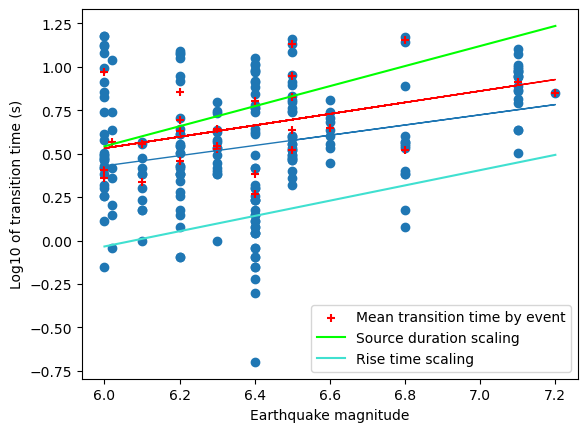

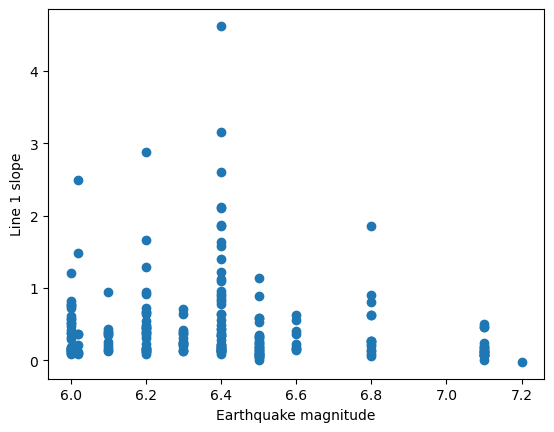

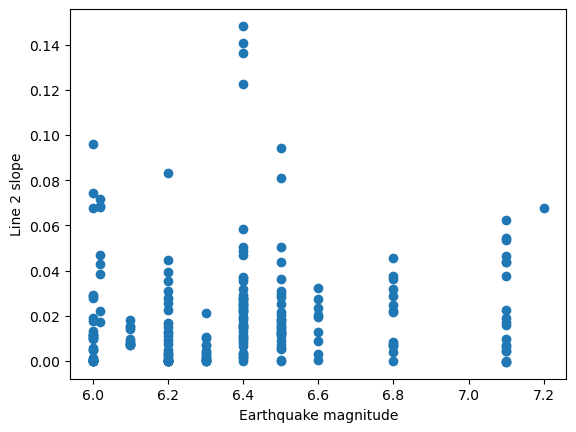

In [19]:
# plt.scatter(mcmc_array[:,3].astype(float), mcmc_array[:,9].astype(float)-10)
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.show()



plt.scatter(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10))
plt.scatter(mags, np.log10(mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
plt.plot(mags, mags * m + b, color = 'red', lw = 1)
plt.plot(mcmc_array[:,1].astype(float), mcmc_array[:,1].astype(float) * ma + ba, color = 'C0', lw = 1)
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
# plt.semilogy()
plt.legend()
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,5].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 1 slope')
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,6].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 2 slope')
plt.show()

In [ ]:
# mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
#                              np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
#                              np.array(sigmas_list), np.array(trans_time_list)))

pd_mcmc = pd.DataFrame(mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path_to_files + 'filtered_mcmc_arrays/mcmc_results_summary.csv', index = False)

In [ ]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path_to_files + 'filtered_mcmc_arrays/mcmc_results_summary.csv')
mcmc_results

In [ ]:
print(np.mean(mcmc_results['m1'].values))
print(np.mean(mcmc_results['m2'].values))
print(np.mean(mcmc_results['xinter'].values))

print(np.median(mcmc_results['m1'].values))
print(np.median(mcmc_results['m2'].values))
print(np.median(mcmc_results['xinter'].values))